<a href="https://colab.research.google.com/github/pi-dee/creating-organ-masks-from-png/blob/main/ct_lung_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
This tutorial covers the following topics:
*   Loading 2D images (PNG) as input to a CNN
*   Developing an encoder-decorder segmentation network (U-Net)

The data used in this exercise includes CT images and organ contours downloaded from The Cancer Imaging Archive: 
> _Yang, Jinzhong; Sharp, Greg; Veeraraghavan, Harini ; van Elmpt, Wouter ; Dekker, Andre; Lustberg, Tim; Gooding, Mark. (2017). Data from Lung CT Segmentation Challenge. The Cancer Imaging Archive. http://doi.org/10.7937/K9/TCIA.2017.3r3fvz08_

Three-dimensionsal CT images and organ contours/masks were converted into the PNG file format. CT images were normalized such (-1000 HU, 1000 HU) became (0, 1).  

Note: make sure your session is connected to a GPU. From the dropdown menu: __Runtime > Change Runtime Type > GPU (or TPU)__

# Preparing data
* Download the data to your local machine. 
* Convert the images to PNG using nii2png
* Upload it to Google Drive: The path used here is /content/drive/MyDrive/png

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import some libraries. Nibabel is our library to handle NIFTI files

In [2]:
import nibabel as nib
import numpy as np
import os
import random

Each folder in /content/drive/MyDrive/png contains data for a different subject:
> /content/drive/MyDrive/png/

 &nbsp;&nbsp;&nbsp;9/  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;labels  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;volumes  
 &nbsp;&nbsp;&nbsp;89/  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;labels  
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;volumes  
 &nbsp;&nbsp;&nbsp;             ...

Store paths to all subjects' data to a list, then randomize the orderering

In [3]:
path_to_images='/content/drive/MyDrive/png'
subject_paths = [i.path for i in os.scandir(path_to_images) if i.is_dir()]

#randomize order
random.seed(1)
random.shuffle(subject_paths)
print(subject_paths)

#which subjects should be validation 
#(note: careful not to include a subject's images in both train and validation)
validation_subjects = [0, 1, 2]

['/content/drive/MyDrive/png/94', '/content/drive/MyDrive/png/96', '/content/drive/MyDrive/png/99', '/content/drive/MyDrive/png/95', '/content/drive/MyDrive/png/93', '/content/drive/MyDrive/png/91', '/content/drive/MyDrive/png/9', '/content/drive/MyDrive/png/92', '/content/drive/MyDrive/png/89', '/content/drive/MyDrive/png/90']


Loop through each subject and do the following:


*   Read each subject's PNG images and masks
*   Resize them 
*   Each PNG represents a sample, stack them as (samples, x_dim, y_dim, channels)
*   Sort them into training and validation data sets

In [4]:
#use CV2 to resample the images
import cv2
from cv2 import resize, INTER_LINEAR, INTER_NEAREST
import numpy.ma as ma
import imageio

resample_dims = 128
#Bones get coded as 255, Kidney as 204
organ_color_code = 255

#initialize arrays (can erase later, but probably doesn't matter)
train_images = np.zeros((1,resample_dims, resample_dims,1))
train_masks_bone =  np.zeros((1,resample_dims, resample_dims,1))
val_images = np.zeros((1,resample_dims, resample_dims,1))
val_masks_bone = np.zeros((1,resample_dims, resample_dims,1))

#loop through, loading each subject's data
for i,subject in enumerate(subject_paths):
  
  #read a subject's stack of 2D images and stack of 2D masks, resize
  l_path = os.path.join(subject, "labels")
  l_paths = [dir.path for dir in os.scandir(l_path) ]
  image_stack_i = np.zeros((1, resample_dims, resample_dims))
  mask_stack_bone_i = np.zeros((1, resample_dims, resample_dims))
  for j, fn in enumerate(l_paths):
    l_basename = os.path.basename(fn)
    v_path = os.path.join(subject, "volume",l_basename.replace("labels", "volume"))
    image_stack_j = resize(cv2.imread(v_path,0),(resample_dims,resample_dims), interpolation=INTER_LINEAR)
    #Add a new dimension for various images of the same nii and normalise the values to between 0 and 1
    image_stack_j = image_stack_j[np.newaxis, :, :]/255. 
    image_stack_i = np.concatenate((image_stack_i, image_stack_j), axis = 0)
    mask_stack_j = resize(cv2.imread(fn,0),(resample_dims,resample_dims), interpolation=INTER_LINEAR)
    mask_stack_bone_j = np.zeros((mask_stack_j.shape))
    mask_stack_bone_j[mask_stack_j == 255] = 1
    mask_stack_bone_j = mask_stack_bone_j[np.newaxis, :, :]
    mask_stack_bone_i = np.concatenate((mask_stack_bone_i, mask_stack_bone_j), axis = 0)


  #this adds the channels dimension (may seem strange, but it is needed)
  image_stack_i = image_stack_i[1:,:,:,np.newaxis]
  mask_stack_bone_i = mask_stack_bone_i[1:,:,:,np.newaxis]

  #add images and masks, split into training and validation
  if i in validation_subjects:
    val_images = np.concatenate((val_images, image_stack_i), axis=0) 
    val_masks_bone = np.concatenate((val_masks_bone, mask_stack_bone_i), axis=0)
  else:
    train_images = np.concatenate((train_images, image_stack_i), axis=0) 
    train_masks_bone = np.concatenate((train_masks_bone, mask_stack_bone_i), axis=0)

In [5]:
#use CV2 to resample the images
import cv2
from cv2 import resize, INTER_LINEAR, INTER_NEAREST
import numpy.ma as ma
import imageio

resample_dims = 128
resample_dims_1 = 512

#initialize arrays (can erase later, but probably doesn't matter)
train_masks_kidney =  np.zeros((1,resample_dims, resample_dims,1))
train_images_kidney =  np.zeros((1,resample_dims, resample_dims,1))
train_masks_kidney2 =  np.zeros((1,resample_dims, resample_dims,1))
val_masks_kidney = np.zeros((1,resample_dims, resample_dims,1))
val_images_kidney =  np.zeros((1,resample_dims, resample_dims,1))
val_masks_kidney2 =  np.zeros((1,resample_dims, resample_dims,1))

#loop through, loading each subject's data
for i,subject in enumerate(subject_paths):
  
  #read a subject's stack of 2D images and stack of 2D masks, resize
  l_path = os.path.join(subject, "labels")
  l_paths = [dir.path for dir in os.scandir(l_path) ]
  #Add a new dimension for various images of the same nii and normalise the values to between 0 and 1
  image_stack_j = image_stack_j[np.newaxis, :, :]/255. 
  mask_stack_kidney_i = np.zeros((1, resample_dims, resample_dims))
  mask_stack_kidney2_i = np.zeros((1, resample_dims, resample_dims))
  image_stack_kidney_i = np.zeros((1, resample_dims, resample_dims))
  for j, fn in enumerate(l_paths):
    l_basename = os.path.basename(fn)
    v_path = os.path.join(subject, "volume",l_basename.replace("labels", "volume"))
    image_stack_j = resize(cv2.imread(v_path,0),(resample_dims,resample_dims), interpolation=INTER_LINEAR)
    #Add a new dimension for various images of the same nii and normalise the values to between 0 and 1
    image_stack_j = image_stack_j[np.newaxis, :, :]/255.
    mask_stack_j = resize(cv2.imread(fn,0),(resample_dims,resample_dims), interpolation=INTER_LINEAR)
    mask_stack_kidney_j = np.zeros((mask_stack_j.shape))
    mask_stack_kidney_j[mask_stack_j == 204] = 1
    mask_stack_kidney_j = mask_stack_kidney_j[np.newaxis, :, :]
    mask_stack_kidney_i = np.concatenate((mask_stack_kidney_i, mask_stack_kidney_j), axis = 0)
    if mask_stack_kidney_j.any():
      mask_stack_kidney2_i = np.concatenate((mask_stack_kidney2_i, mask_stack_kidney_j), axis = 0)
      image_stack_kidney_i = np.concatenate((image_stack_kidney_i,image_stack_j ), axis = 0)


  #this adds the channels dimension (may seem strange, but it is needed)
  mask_stack_kidney_i = mask_stack_kidney_i[1:,:,:,np.newaxis]
  image_stack_kidney_i = image_stack_kidney_i[1:,:,:,np.newaxis]
  mask_stack_kidney2_i = mask_stack_kidney2_i[1:,:,:,np.newaxis]
  
  #add images and masks, split into training and validation
  if i in validation_subjects:
    val_masks_kidney = np.concatenate((val_masks_kidney, mask_stack_kidney_i), axis=0)
    val_images_kidney = np.concatenate((val_images_kidney, image_stack_kidney_i), axis=0)
    val_masks_kidney2 = np.concatenate((val_masks_kidney2, mask_stack_kidney2_i), axis=0)
  else:
    train_masks_kidney = np.concatenate((train_masks_kidney, mask_stack_kidney_i), axis=0)
    train_images_kidney = np.concatenate((train_images_kidney, image_stack_kidney_i), axis=0)
    train_masks_kidney2 = np.concatenate((train_masks_kidney2, mask_stack_kidney2_i), axis=0)

In [6]:
val_images = val_images[1:]
val_images_kidney = val_images_kidney[1:]
val_masks_bone = val_masks_bone[1:]
val_masks_kidney = val_masks_kidney[1:]
val_masks_kidney2 = val_masks_kidney2[1:]
train_images = train_images[1:]
train_images_kidney = train_images_kidney[1:]
train_masks_bone = train_masks_bone[1:]
train_masks_kidney = train_masks_kidney[1:]
train_masks_kidney2 = train_masks_kidney2[1:]

Let's inspect the images, to make sure they look like what we expect (very important!). You can run this block many times with a random slice being shown each time it's run. 

384
(128, 128)


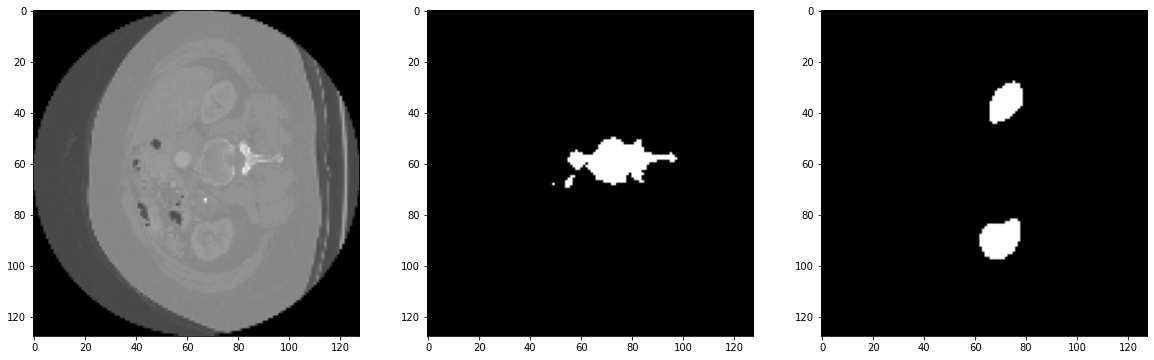

In [8]:
from matplotlib import pyplot as plt
import skimage.color
import skimage.io
# set plotting to be in-line
%matplotlib inline

#view random slice, concatenating the image and mask next to each other
random_slice =random.randint(0,val_images.shape[0])
print(random_slice)
print(str(train_images[random_slice,:,:,0].shape))

fig = plt.figure(figsize=(20,6))

rows = 1
columns = 3
fig.add_subplot(rows, columns, 1)
plt.imshow(train_images[random_slice,:,:,0], cmap='gray')
fig.add_subplot(rows, columns, 2)
plt.imshow(train_masks_bone[random_slice,:,:,0], cmap='gray' )
fig.add_subplot(rows, columns, 3)
plt.imshow(train_masks_kidney[random_slice,:,:,0], cmap='gray' )

#Model building and training
First load some essential libraries for model building

In [9]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import concatenate
# also, import the Model function for building the model
from tensorflow.keras import Model

Build a 5-level encoder module (ie, 4 down-sampling steps) with skip connections to a mirror-image decoder module.
The number of filters can be altered -- this is a "small" version of the U-Net

In [10]:
# create our input layer by giving it an input shape
input_layer = Input(shape=train_images.shape[1:])

#level 1
conv1_en = Conv2D(8, 3, activation = 'relu', padding = 'same')(input_layer)
pool1_en = MaxPooling2D(pool_size=(2, 2))(conv1_en)
#level 2
conv2_en = Conv2D(16, 3, activation = 'relu', padding = 'same')(pool1_en)
pool2_en = MaxPooling2D(pool_size=(2, 2))(conv2_en)
#level 3
conv3_en = Conv2D(32, 3, activation = 'relu', padding = 'same')(pool2_en)
pool3_en = MaxPooling2D(pool_size=(2, 2))(conv3_en)
#level 4
conv4_en = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool3_en)
pool4_en = MaxPooling2D(pool_size=(2, 2))(conv4_en)

#bottom level
conv_bottom = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool4_en)

#level 4 - DECODER
up4_dec = UpSampling2D(size = (2,2))(conv_bottom)
conv4_dec = concatenate([conv4_en,up4_dec])
conv4_dec = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv4_dec)
#level 3 - DECODER
up3_dec = UpSampling2D(size = (2,2))(conv4_dec)
conv3_dec = concatenate([conv3_en,up3_dec])
conv3_dec = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv3_dec)
#level 2 - DECODER
up2_dec = UpSampling2D(size = (2,2))(conv3_dec)
conv2_dec = concatenate([conv2_en,up2_dec])
conv2_dec = Conv2D(16, 3, activation = 'relu', padding = 'same')(conv2_dec)
#level 1 - DECODER
up1_dec = UpSampling2D(size = (2,2))(conv2_dec)
conv1_dec = concatenate([conv1_en,up1_dec])
conv1_dec = Conv2D(8, 3, activation = 'relu', padding = 'same')(conv1_dec)

#output level
conv_out = Conv2D(8, 3, activation = 'relu', padding = 'same')(conv1_dec)
conv_out = Conv2D(1, 3, activation = 'sigmoid', padding='same')(conv_out)

#define inputs/outpus
unet = Model(inputs = input_layer, outputs = conv_out)

Inspect the model

In [ ]:
#show model summary
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 8)  80          ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 8)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 16)   1168        ['max_pooling2d[0][0]']      

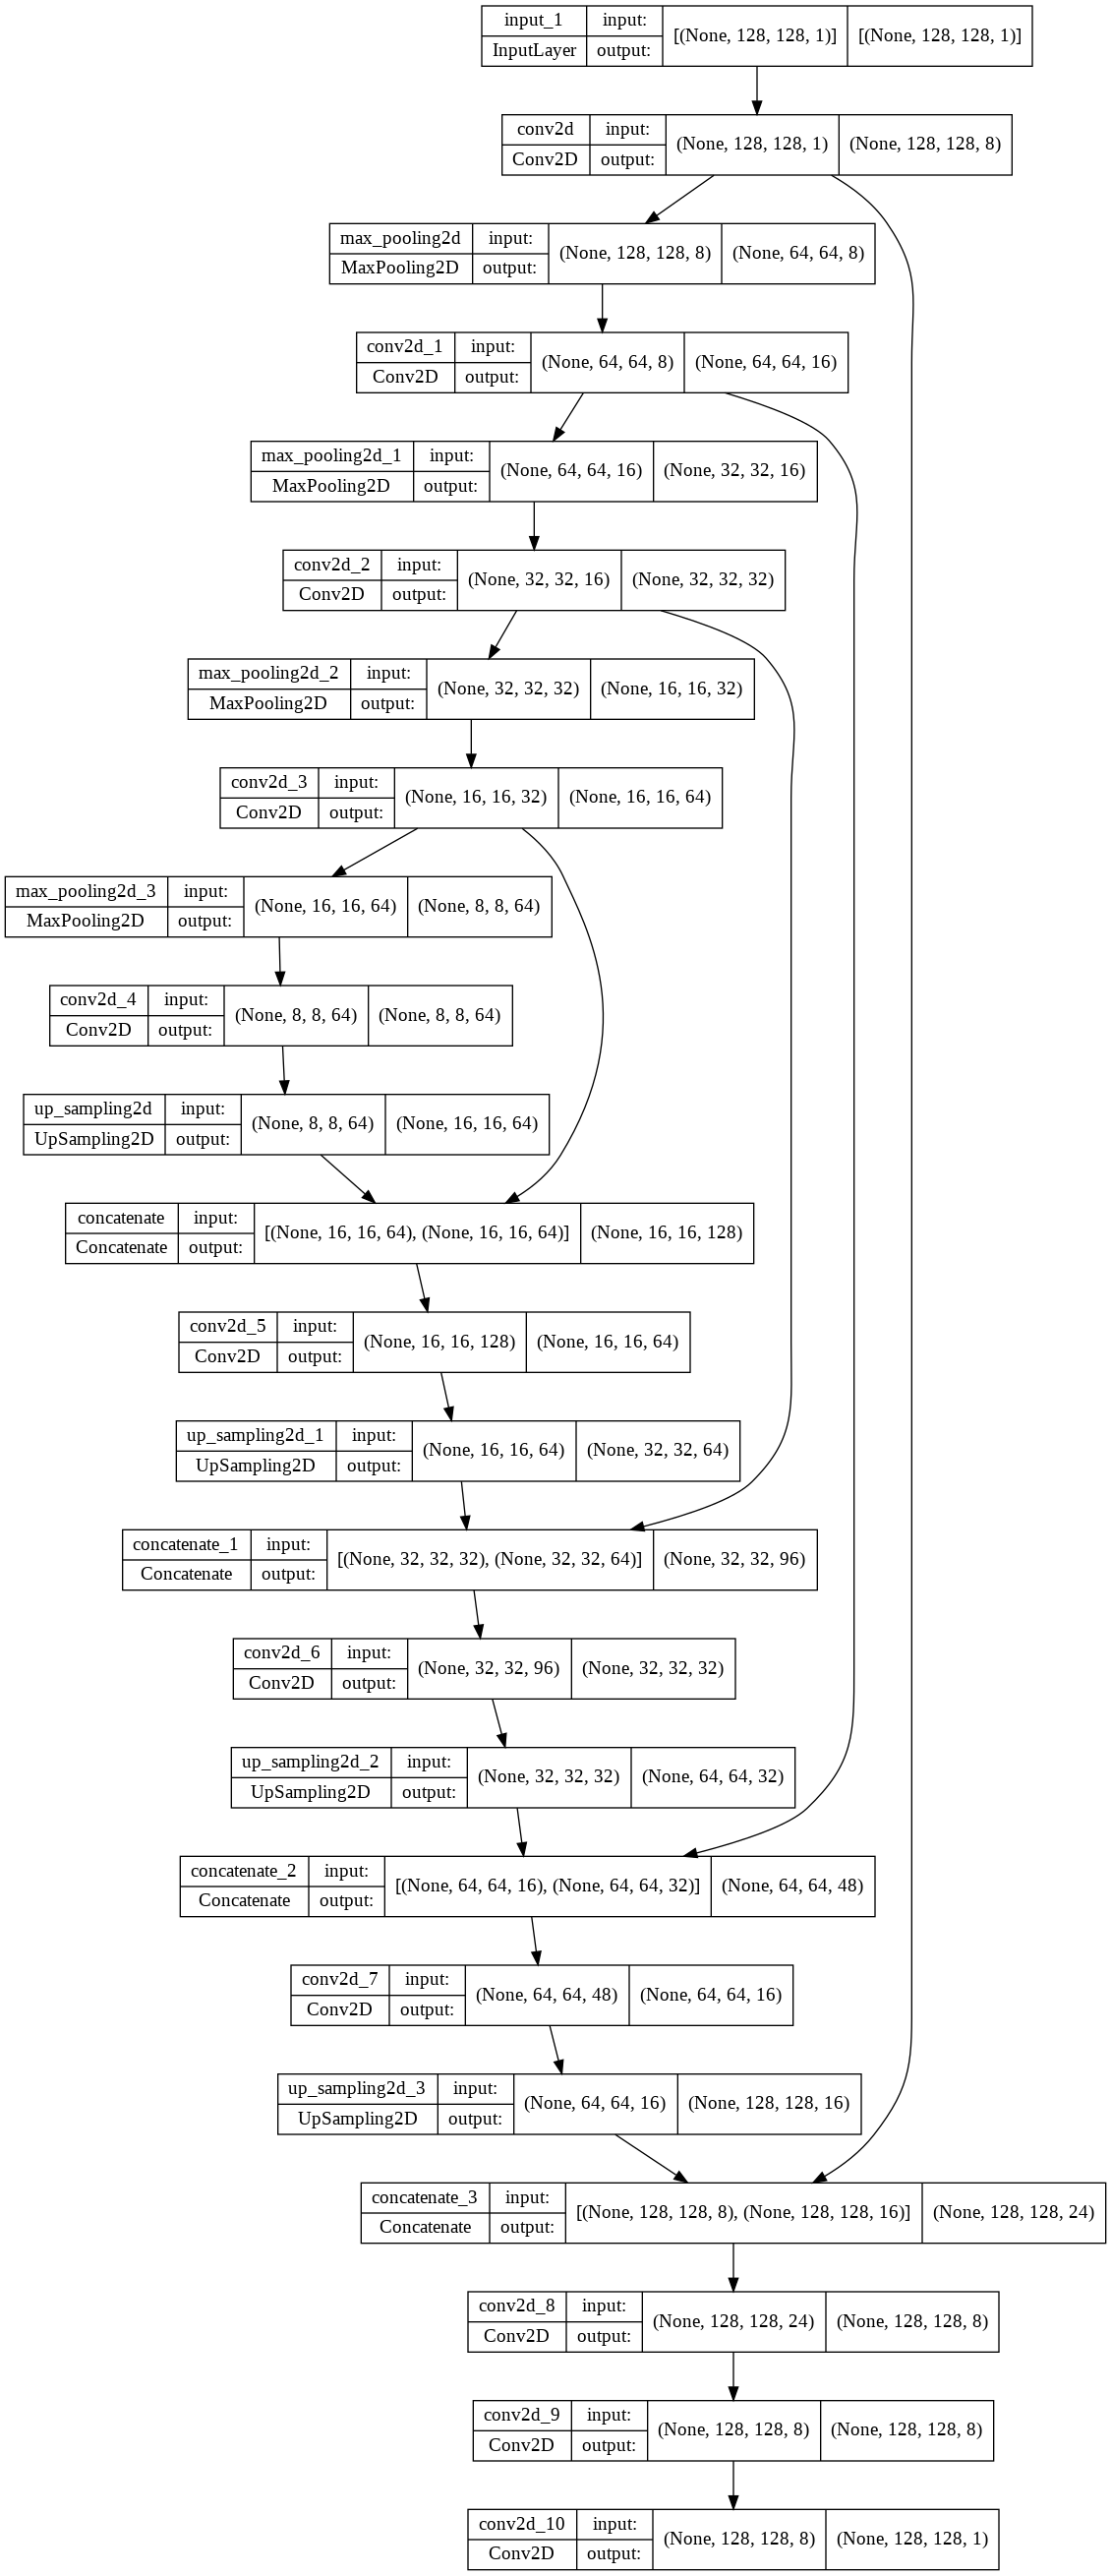

In [ ]:
#you can also create a figure
from tensorflow.keras.utils import plot_model
plot_model(unet, show_shapes=True)

Compile and train the model. All the training results get stored in _history_ variable

In [11]:
from tensorflow.keras import optimizers

#I tried several combinations, RMSprop with lr=0.001 worked for me
unet.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(learning_rate=0.001))

In [12]:
history_bone = unet.fit(x=train_images, y=train_masks_bone,
          batch_size=32,
          epochs=10,
          verbose=1,
          shuffle=True,
          validation_data=(val_images, val_masks_bone))

Epoch 1/10
163/163 [==============================] - 28s 99ms/step - loss: 0.2963 - val_loss: 0.1063
Epoch 2/10
163/163 [==============================] - 14s 88ms/step - loss: 0.1025 - val_loss: 0.0665
Epoch 3/10
163/163 [==============================] - 14s 88ms/step - loss: 0.0686 - val_loss: 0.0573
Epoch 4/10
163/163 [==============================] - 14s 88ms/step - loss: 0.0518 - val_loss: 0.0610
Epoch 5/10
163/163 [==============================] - 14s 88ms/step - loss: 0.0418 - val_loss: 0.0644
Epoch 6/10
163/163 [==============================] - 14s 88ms/step - loss: 0.0354 - val_loss: 0.0545
Epoch 7/10
163/163 [==============================] - 14s 89ms/step - loss: 0.0310 - val_loss: 0.1094
Epoch 8/10
163/163 [==============================] - 14s 89ms/step - loss: 0.0279 - val_loss: 0.0688
Epoch 9/10
163/163 [==============================] - 14s 89ms/step - loss: 0.0255 - val_loss: 0.0841
Epoch 10/10
163/163 [==============================] - 14s 89ms/step - loss: 0.023

Now inspect the results. First look at the loss plot. Change the _plt.ylim_ as appropriate

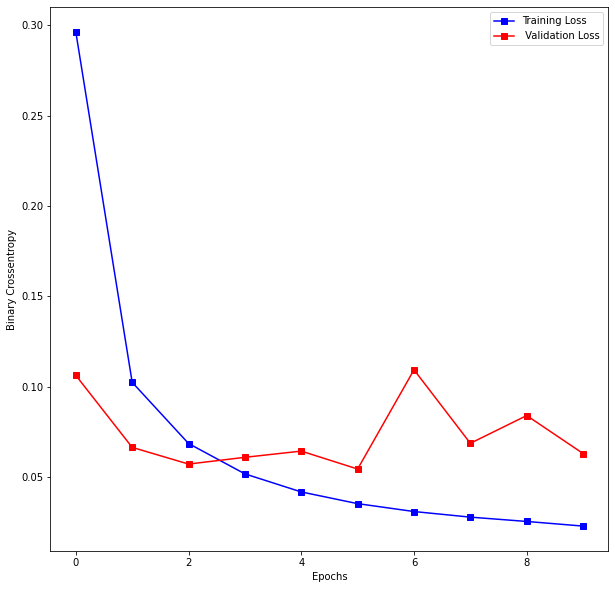

In [13]:
# Plot the losses that are stored in the 'hist' variable

plt.figure(figsize=(10,10));
plt.plot(history_bone.epoch,history_bone.history['loss'],'b-s')
plt.plot(history_bone.epoch,history_bone.history['val_loss'],'r-s')
plt.legend(['Training Loss',
            ' Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.show()

Show the images with the results. First run the unet  model using our validation images as input. Then show the input image next to the ground truth mask and the predicted mask.

In [14]:
#apply the unet to our validation images
predictions_bone = unet.predict(val_masks_bone, verbose=1)

71/71 [==============================] - 2s 27ms/step


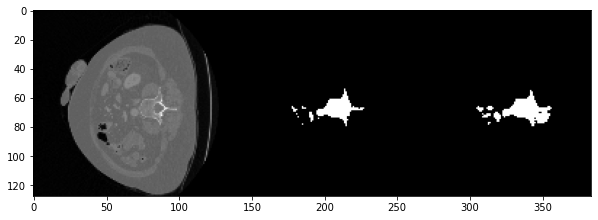

(128, 128)


In [15]:
#show random images with the predicted results
from matplotlib import pyplot as plt
import skimage.color
import skimage.io
# set plotting to be in-line
%matplotlib inline
random_slice = random.randint(0,val_images.shape[0])
fig = plt.figure(figsize=(10,10))
im_slice = val_images[random_slice,:,:,0]
true_mask_slice = val_masks_bone[random_slice,:,:,0]
pred_mask_slice = predictions_bone[random_slice,:,:,0]
plt.imshow(np.c_[im_slice, true_mask_slice, np.round(pred_mask_slice)],  cmap='gray')
plt.show()
print(im_slice.shape)

In [16]:
history_kidney = unet.fit(x=train_images_kidney, y=train_masks_kidney2,
          batch_size=32,
          epochs=15,
          verbose=1,
          shuffle=True,
          validation_data=(val_images_kidney, val_masks_kidney2))

Epoch 1/15
82/82 [==============================] - 8s 96ms/step - loss: 0.0177 - val_loss: 0.0595
Epoch 2/15
82/82 [==============================] - 7s 83ms/step - loss: 0.0074 - val_loss: 0.0531
Epoch 3/15
82/82 [==============================] - 7s 84ms/step - loss: 0.0062 - val_loss: 0.0647
Epoch 4/15
82/82 [==============================] - 7s 84ms/step - loss: 0.0044 - val_loss: 0.1024
Epoch 5/15
82/82 [==============================] - 7s 84ms/step - loss: 0.0036 - val_loss: 0.1345
Epoch 6/15
82/82 [==============================] - 7s 84ms/step - loss: 0.0034 - val_loss: 0.0994
Epoch 7/15
82/82 [==============================] - 7s 84ms/step - loss: 0.0030 - val_loss: 0.1118
Epoch 8/15
82/82 [==============================] - 7s 84ms/step - loss: 0.0032 - val_loss: 0.0929
Epoch 9/15
82/82 [==============================] - 7s 83ms/step - loss: 0.0024 - val_loss: 0.1057
Epoch 10/15
82/82 [==============================] - 7s 84ms/step - loss: 0.0024 - val_loss: 0.1270
Epoch 11/

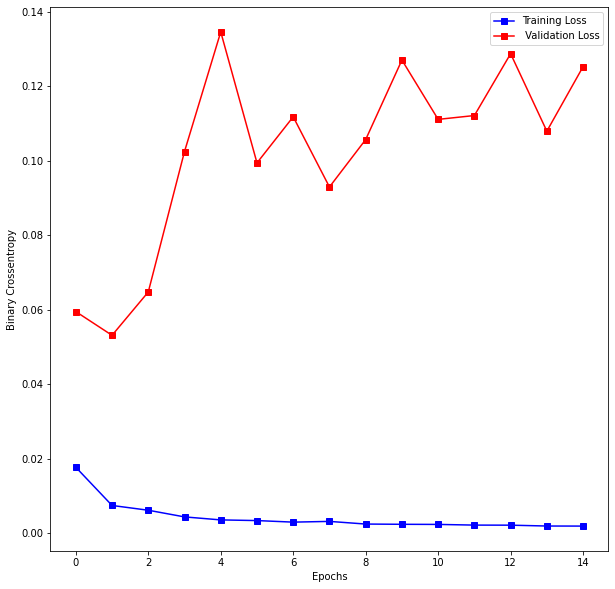

In [17]:
# Plot the losses that are stored in the 'hist' variable
from matplotlib import pyplot as plt
import skimage.color
import skimage.io
# set plotting to be in-line
%matplotlib inline
plt.figure(figsize=(10,10));
plt.plot(history_kidney.epoch,history_kidney.history['loss'],'b-s')
plt.plot(history_kidney.epoch,history_kidney.history['val_loss'],'r-s')
plt.legend(['Training Loss',
            ' Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.show()

In [18]:
#apply the unet to our validation images
predictions_kidney = unet.predict(val_masks_kidney2, verbose=1)

22/22 [==============================] - 1s 30ms/step


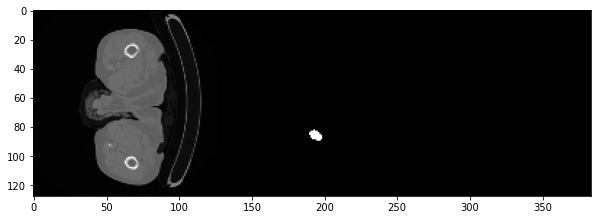

(128, 128)


In [22]:
#show random images with the predicted results
from matplotlib import pyplot as plt
import skimage.color
import skimage.io
# set plotting to be in-line
%matplotlib inline
random_slice = random.randint(0,val_images.shape[0])
fig = plt.figure(figsize=(10,10))
im_slice = val_images[random_slice,:,:,0]
true_mask_slice = val_masks_kidney2[random_slice,:,:,0]
pred_mask_slice = predictions_kidney[random_slice,:,:,0]
plt.imshow(np.c_[im_slice, true_mask_slice, np.round(pred_mask_slice)],  cmap='gray')
plt.show()
print(im_slice.shape)

In [ ]:
#save your model (optional)
unet.save('/home/unet_lung_segmation_model.hdf5')